In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = (
    False  # Plotting the global model is much much faster with tex fonts turned off
)

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-07-09 20:52:01.131 | INFO     | celeri.celeri:get_logger:5423 - Read: ../data/command/western_north_america_command.json
2024-07-09 20:52:01.133 | INFO     | celeri.celeri:get_logger:5424 - RUN_NAME: 2024-07-09-20-52-01
2024-07-09 20:52:01.134 | INFO     | celeri.celeri:get_logger:5425 - Write log file: ../runs/2024-07-09-20-52-01/2024-07-09-20-52-01.log
2024-07-09 20:52:01.135 | INFO     | celeri.celeri:read_data:231 - Reading data files
2024-07-09 20:52:01.141 | SUCCESS  | celeri.celeri:read_data:235 - Read: ../data/segment/western_north_america_segment.csv
2024-07-09 20:52:01.143 | SUCCESS  | celeri.celeri:read_data:240 - Read: ../data/block/western_north_america_block.csv
2024-07-09 20:52:01.145 | SUCCESS  | celeri.celeri:read_data:247 - Read: ../data/mesh/western_north_america_mesh_parameters.json

2024-07-09 20:52:01.301 | SUCCESS  | celeri.celeri:read_data:393 - Read: ../data/mesh/cascadia.msh
2024-07-09 20:52:01.304 | SUCCESS  | celeri.celeri:read_data:429 - Read: ../data/

# Get elastic operators and TDE smoothing operators

In [5]:
command.reuse_elastic = 0

# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-07-09 20:52:02.070 | INFO     | celeri.celeri:get_elastic_operators:1600 - Computing elastic operators


Calculating Okada partials for segments: 100%|██████████| 837/837 [00:12<00:00, 68.62it/s]

2024-07-09 20:52:14.290 | INFO     | celeri.celeri:get_elastic_operators:1608 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/cascadia.msh



Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:10<00:00, 184.00it/s]

2024-07-09 20:52:24.298 | SUCCESS  | celeri.celeri:get_elastic_operators:1614 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/cascadia.msh
2024-07-09 20:52:24.298 | INFO     | celeri.celeri:get_elastic_operators:1624 - Saving elastic to velocity matrices to :../data/operators/western_north_america_elastic_operators.hdf5


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-07-09 20:52:24.883 | INFO     | celeri.celeri:get_slip_rate_constraints:2814 - Found 1 slip rate constraints
2024-07-09 20:52:24.887 | INFO     | celeri.celeri:get_slip_rate_constraints:2817 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Plot input data

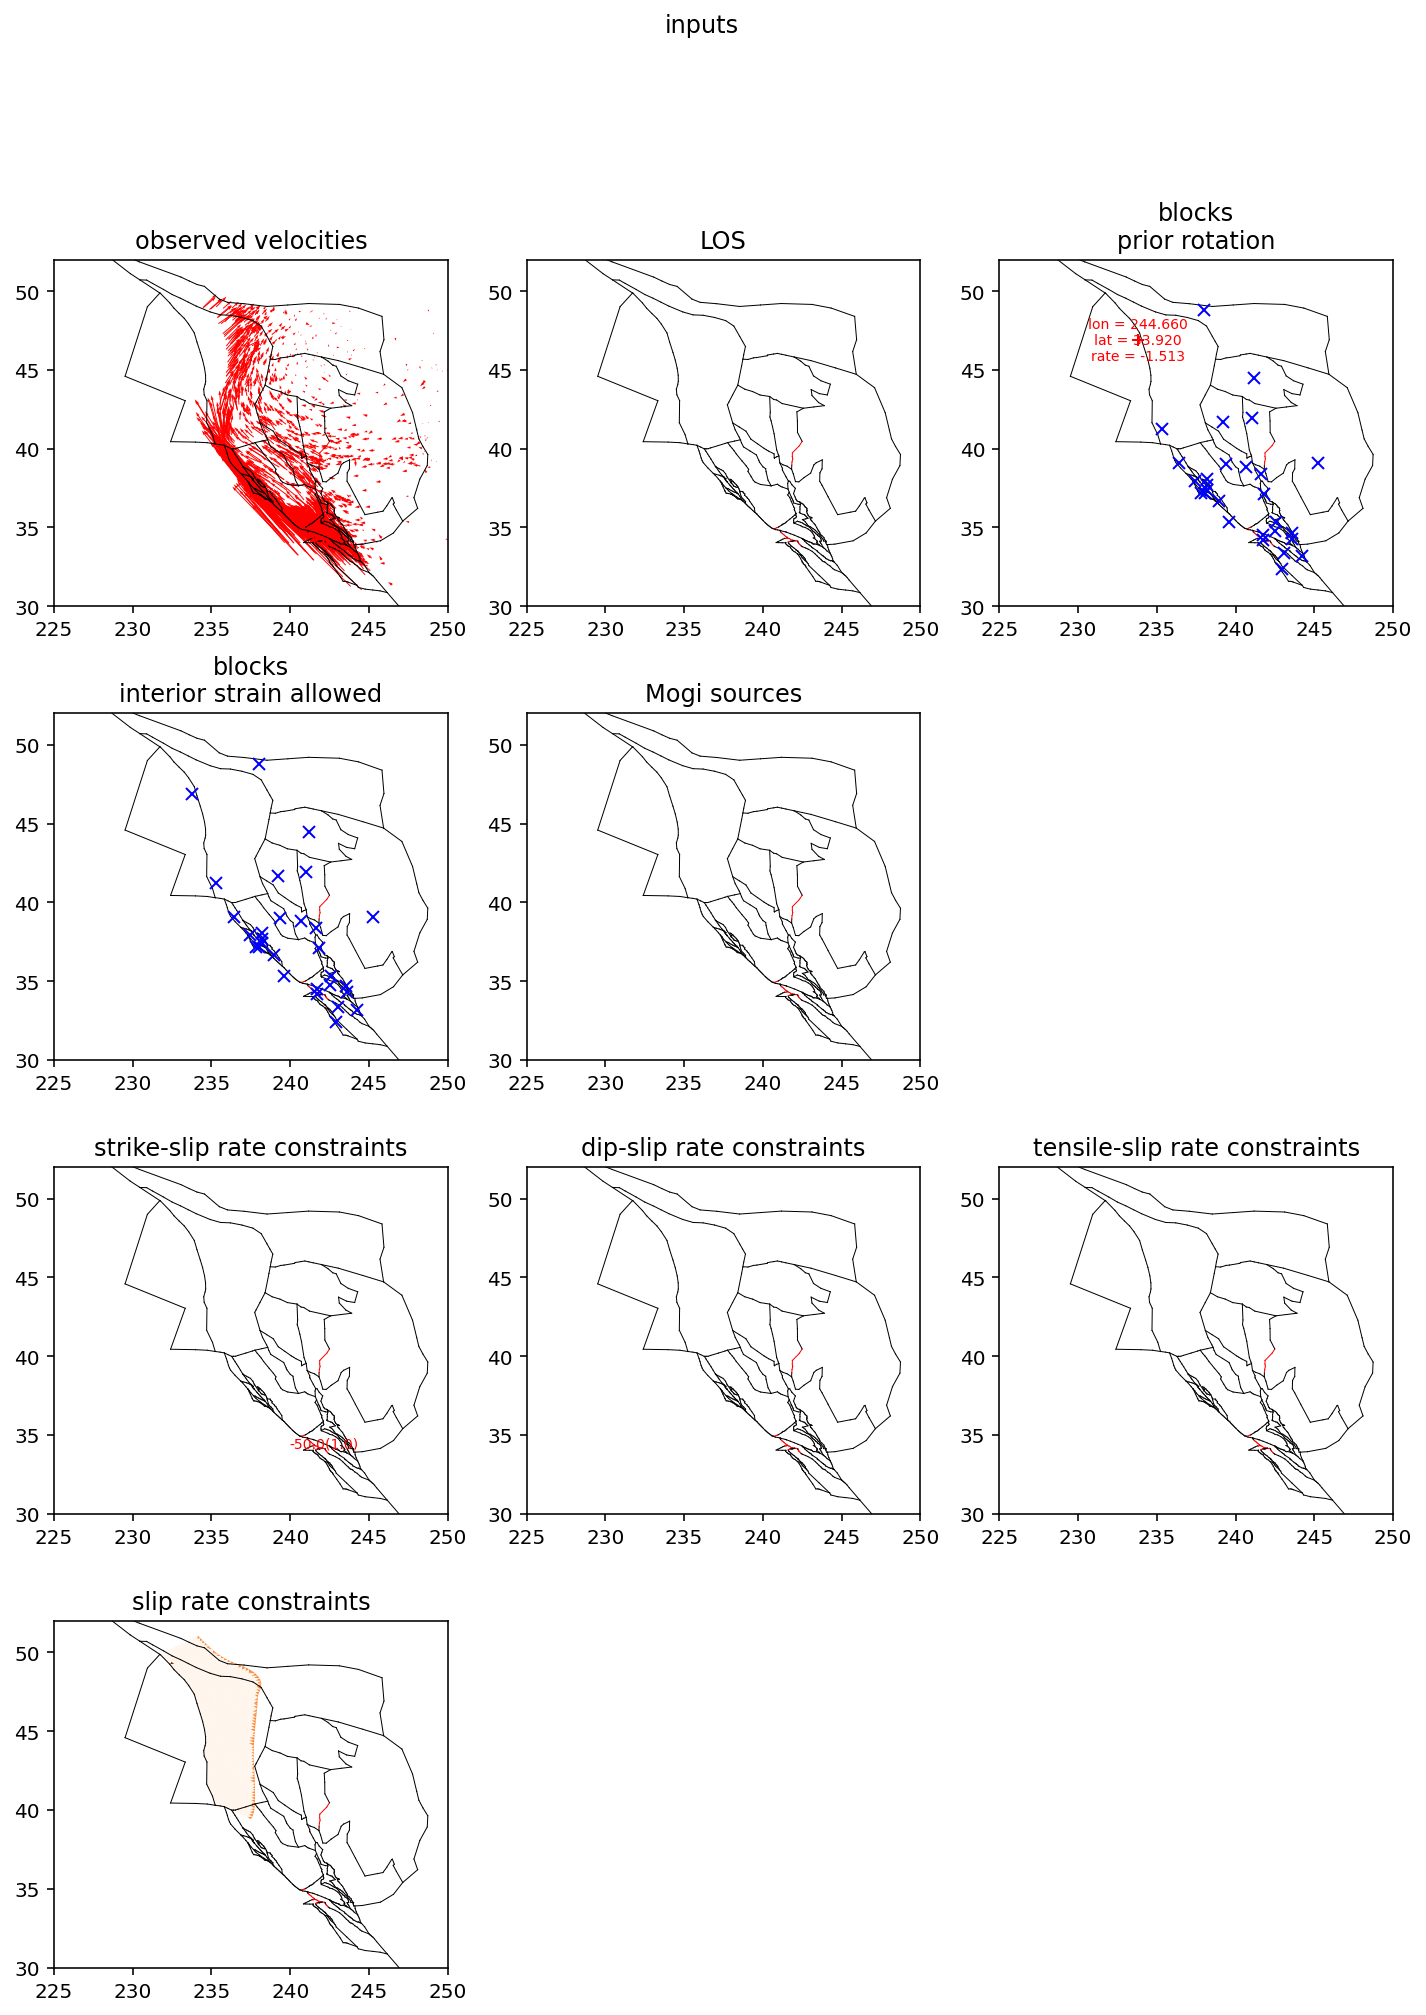

2024-07-09 20:52:28.771 | SUCCESS  | celeri.celeri:plot_input_summary:5048 - Wrote figures../runs/2024-07-09-20-52-01/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [8]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

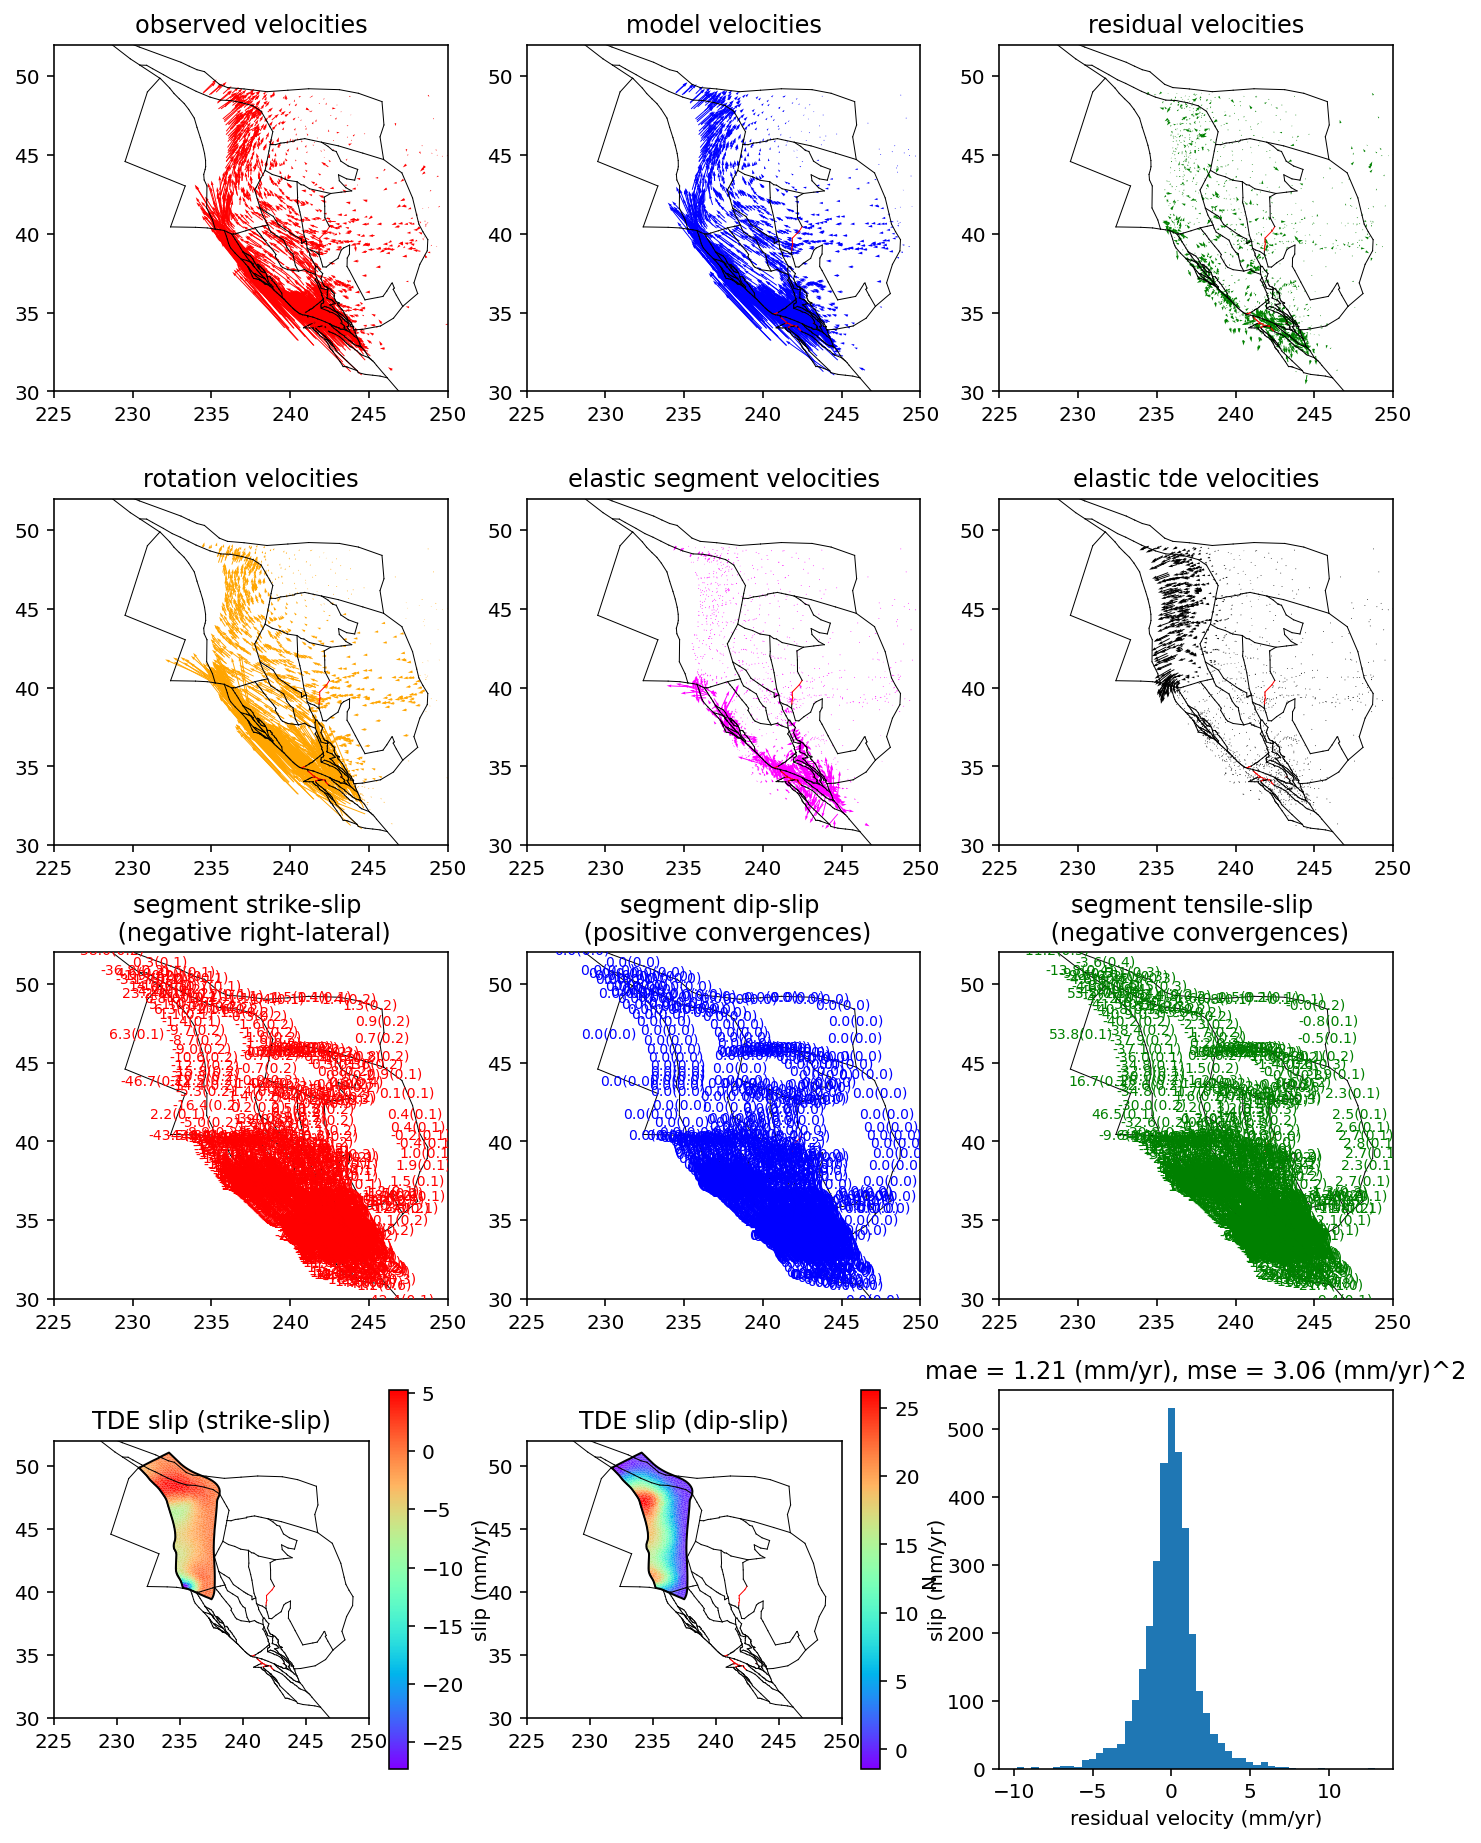

2024-07-09 20:52:38.135 | SUCCESS  | celeri.celeri:plot_estimation_summary:5388 - Wrote figures../runs/2024-07-09-20-52-01/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [9]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

In [15]:
# # outfile = TemporaryFile()
# np.savez(
#     "testing_select_wna_arrays.npz",
#     estimation_slip_rates=estimation.slip_rates,
#     estimation_tde_rates=estimation.tde_rates,
#     estimation_east_vel_residual=estimation.east_vel_residual,
#     estimation_north_vel_residual=estimation.north_vel_residual,
# )

In [27]:
testing_select_wna_arrays = np.load("testing_select_wna_arrays.npz")
assert np.allclose(
    estimation.slip_rates, testing_select_wna_arrays["estimation_slip_rates"]
)
assert np.allclose(
    estimation.tde_rates, testing_select_wna_arrays["estimation_tde_rates"]
)
assert np.allclose(
    estimation.east_vel_residual,
    testing_select_wna_arrays["estimation_east_vel_residual"],
)
assert np.allclose(
    estimation.north_vel_residual,
    testing_select_wna_arrays["estimation_north_vel_residual"],
)